In [1]:
#Loading the Libraries We need 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, concatenate# type: ignore
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D# type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer# type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences# type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns


In [13]:
#Loading Training DataSet
df=pd.read_csv("hateful_memes_original.csv")

In [2]:
#we will be using GPU for model training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        

In [14]:
#Arrays/List to store data from csv files
Labels=[]
text=[]
img=[]

In [15]:
for i in range(len(df)):
    Labels.append(df.label.iloc[i])
    text.append(df.text.iloc[i])
    img.append((df.img.iloc[i]))

In [3]:
#preprocessing function to load the image from given path and then resizing it to (200,200)
def pre_process(img):
    img=cv.imread(img)
    img=cv.resize(img,(200,200))
    return img

In [17]:
#loading images from the path using preprocessing function
train_images = [pre_process(image_path) for image_path in img]

In [18]:
#converting every List to a numpy array otherwise tensorflow will throw some error 
t_i=np.array(train_images)
Labels=np.array(Labels)

In [19]:
#word embedings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=70, padding='post')
padded_sequences=np.array(padded_sequences)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
#spliting the data according i 80-20 ratio
text_train, text_val, img_train, img_val, Labels_train, Labels_val = train_test_split(padded_sequences, t_i, Labels, test_size=0.2, random_state=42)

In [21]:
#using generator for data loading because they are efficient way to load large datasets
def data_generator(padded_sequences, images, labels, batch_size):
    num_samples = len(padded_sequences)
    num_batches = num_samples // batch_size
    while True:
        
        indices = np.random.permutation(num_samples)
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = (batch_idx + 1) * batch_size
            batch_indices = indices[start_idx:end_idx]
            batch_padded_sequences = padded_sequences[batch_indices]
            batch_images = images[batch_indices]
            batch_labels = labels[batch_indices]
            yield [batch_padded_sequences, batch_images], batch_labels

In [22]:
train_generator = data_generator(text_train, img_train, Labels_train, 32)
val_generator = data_generator(text_val, img_val, Labels_val, 32)
#32 here is batch size

In [23]:


# Define parameters
embedding_dim = 50  #embedding dimension
lstm_units = 32  #LSTM units
batch_size = 32  #batch size

text_input = Input(shape=(max_sequence_length,)) # Input for text data
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(text_input) # Embedding layer for text data


lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)  # Bidirectional LSTM layer for text data
text_flatten = Flatten()(lstm_layer)
text_dropout = Dropout(0.5)(text_flatten) #dropout layer to prevent overfit
text_output = Dense(32, activation='relu')(text_dropout)   # Dense layer for text output


#cnn layers for image data, 2 cnn layer and 2 maxpooling layer ,one dropout layer to prevent overfit
image_input = Input(shape=(200,200,3))
conv_layer1 = Conv2D(16, kernel_size=(3, 3), activation='relu')(image_input)   #cnn layer_1 
maxpool_layer1 = MaxPooling2D(pool_size=(2, 2))(conv_layer1)
conv_layer2 = Conv2D(32, kernel_size=(3, 3), activation='relu')(maxpool_layer1) #cnn layer_2
maxpool_layer2 = MaxPooling2D(pool_size=(2, 2))(conv_layer2)
image_flatten = Flatten()(maxpool_layer2)
image_dropout = Dropout(0.5)(image_flatten)  #dropout layer to prevent overfit
image_output = Dense(32, activation='relu')(image_dropout)  


concatenated = concatenate([text_output, image_output]) # Concatenate the text and image layers


dense_layer = Dense(32, activation='relu')(concatenated) #extra layer for further processing


output_layer = Dense(1, activation='sigmoid')(dense_layer) #output layer with only one neuron 


model = Model(inputs=[text_input, image_input], outputs=output_layer) #defining our model


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compiling with optimizer, loss function

epoch_train = len(text_train) // batch_size
epoch_val = len(text_val) // batch_size 


model.fit_generator(train_generator, steps_per_epoch=epoch_train,validation_data=val_generator, 
                    validation_steps=epoch_val,epochs=10) # Train the model using a generator



Epoch 1/10


C:\Users\ayush\AppData\Local\Temp\ipykernel_7004\281353826.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=epoch_train,validation_data=val_generator,


250/250 [==============================] - 25s 48ms/step - loss: 1.9764 - accuracy: 0.6114 - val_loss: 0.6013 - val_accuracy: 0.6850
Epoch 2/10
250/250 [==============================] - 10s 41ms/step - loss: 0.5147 - accuracy: 0.7509 - val_loss: 0.6105 - val_accuracy: 0.6845
Epoch 3/10
250/250 [==============================] - 10s 39ms/step - loss: 0.3832 - accuracy: 0.8219 - val_loss: 0.7286 - val_accuracy: 0.6653
Epoch 4/10
250/250 [==============================] - 10s 39ms/step - loss: 0.2881 - accuracy: 0.8766 - val_loss: 0.8398 - val_accuracy: 0.6386
Epoch 5/10
250/250 [==============================] - 10s 39ms/step - loss: 0.2152 - accuracy: 0.9120 - val_loss: 0.9292 - val_accuracy: 0.6270
Epoch 6/10
250/250 [==============================] - 10s 39ms/step - loss: 0.1765 - accuracy: 0.9255 - val_loss: 1.1178 - val_accuracy: 0.6003
Epoch 7/10
250/250 [==============================] - 10s 39ms/step - loss: 0.1278 - accuracy: 0.9511 - val_loss: 1.6057 - val_accuracy: 0.6245
Epo

In [24]:
model.save("MODEL.h5")

In [4]:
mod=tf.keras.models.load_model("MODEL.h5")


In [5]:
#function to calculate best threshold for classification

def find_best_threshold( X, y):

  
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(X, y)

    # Find the threshold that maximizes the Youden's J statistic
    best_threshold_index = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_threshold_index]
    
    return best_threshold
    


In [ ]:
pre=mod.predict([padded_sequences,t_i]) #prediction on trainingset to get best threeshold

In [28]:
sd=find_best_threshold(Labels,pre)

In [8]:
#single function to calculate all Evaluation matrix
def calculate_evaluation_metrics(true_labels, predicted_labels):
    
    acc = accuracy_score(true_labels, predicted_labels)
    
    
    Precision = precision_score(true_labels, predicted_labels)
    
   
    recall = recall_score(true_labels, predicted_labels)
    
    
    f_1 = f1_score(true_labels, predicted_labels)
    
    
    c_matrix = confusion_matrix(true_labels, predicted_labels)
    
    return acc, Precision, recall, f_1, c_matrix


#to convert the predicted probabilities to proper binary classification

def classification(predicted_probs, threshold):

    labels = np.zeros_like(predicted_probs)  # Initialize binary labels array
    labels[predicted_probs >= threshold] = 1  # Assign 1 to instances with probability >= sd
    return labels

Evaluation Metrics:

In [36]:
f_p=classification(pre,sd) #predicting with proper threeshold in final classification 0 or 1

In [31]:
acc,prec,recl,f1,cma=calculate_evaluation_metrics(Labels,f_p) #for training dataset

In [26]:
#to calculate tpr and fpr
tn, fp, fn, tp = cma.ravel()
tp1 = tp / (tp + fn)  #TPR

fp1 = fp / (fp + tn) #FPR


In [33]:
#on scale of 0-100 percent
print("Accuracy is ",acc*100)
print("Precision is ",prec*100)
print("Recall is ",recl*100)
print("F-1 score is ",f1*100)



Accuracy is  91.75
Precision is  87.60585065434951
Recall is  90.89456869009584
F-1 score is  89.21991375931007


Confusion Matrix

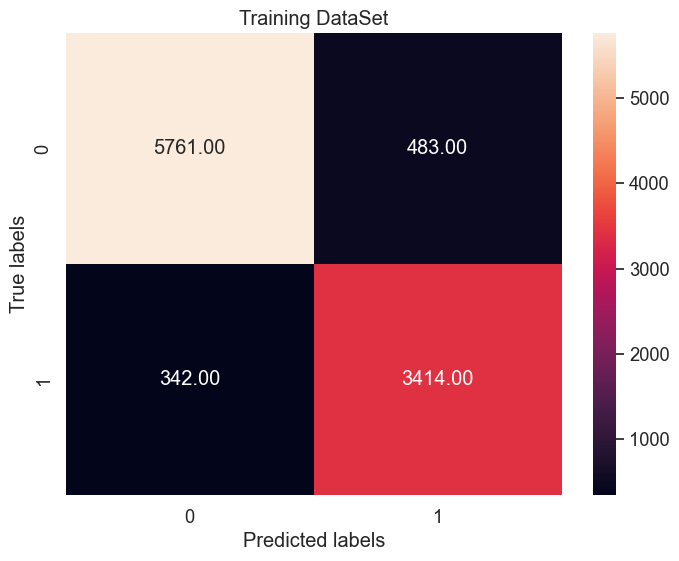

In [34]:
#ploting confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cma, annot=True,fmt='.2f') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Training DataSet")
plt.show()

ROC_CURVE for training data


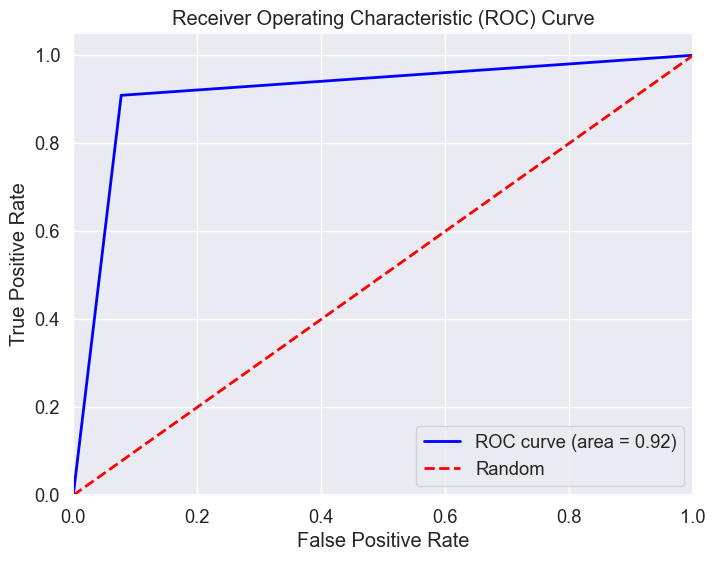

In [37]:
fpr, tpr ,th= roc_curve(Labels,f_p)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Testing on Test_Datasets

In [9]:
#writing a function for whole pre-processing, (we are just combining every cells which is used to pre-process our training dataset)

def complete_pre_process(path_to_data_set):
    df=pd.read_csv(path_to_data_set)
    Labels=[]
    text=[]
    img=[]
    for i in range(len(df)):
        Labels.append(df.labels.iloc[i])
        text.append(df.text.iloc[i])
        img.append((df.image.iloc[i]))
    for i in range(len(Labels)):
      
        temp=Labels[i]
        if(temp=="harmful"):
            Labels[i]=1
        else:
            Labels[i]=0
      
    train_images = [pre_process(f"TESTING\ALL_IMAGES\{image_path}") for image_path in img]  #pre_process is defined above
    #we pasted images from both dataset in a single folder just to reduce if/else conditions otherwise we have to make condition for both path  
    #even images are in one folder it will only pick image related to their dataset  
    t_i=np.array(train_images)
    Labels=np.array(Labels)
    text = [str(item)  if isinstance(item, str) else "No Information" for item in text]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    
    padded_sequences = pad_sequences(sequences, maxlen=70, padding='post')
    padded_sequences=np.array(padded_sequences)

    return padded_sequences,t_i,Labels
    
    

In [10]:
T_1,I_1,L_1=complete_pre_process("TESTING\harmful_data_for_covid19\haemful_meme_for_covid19.csv")

In [33]:
T_2,I_2,L_2=complete_pre_process("TESTING\harmful_meme_politics\harmful_meme_for_politics.csv")

PREDICTIONS

In [26]:
P_1=mod.predict([T_1,I_1]) 

111/111 [==============================] - 2s 15ms/step


In [43]:
P_2=mod.predict([T_2,I_2])

111/111 [==============================] - 2s 15ms/step


In [27]:
P_1=classification(P_1,sd) #binary classification function to predict the class according to threshold sd/


In [28]:
P_1=P_1.astype(int) #converting array type to int from float

In [44]:
P_2=classification(P_2,sd)

In [47]:
P_2=P_2.astype(int)


Results for  test_data_set 1

In [30]:
A_1,p_1,R_1,F_1,C_1=calculate_evaluation_metrics(L_1,P_1) #function defined above

In [31]:
tn, fp, fn, tp = C_1.ravel()
tp = tp / (tp + fn)  #TPR
fp = fp / (fp + tn) #FPR

In [32]:
print("Results for Covid-19 Memes DataSET ")
print("Accuracy is ",A_1*100)
print("Precision is ",p_1*100)
print("Recall is ",R_1*100)
print("F-1 score is ",F_1*100)
print("True positive Rate (TPR) is",tp*100)
print("False positive Rate (FPR) is",fp*100)


Results for Covid-19 Memes DataSET 
Accuracy is  67.57900677200904
Precision is  53.50140056022409
Recall is  61.1689351481185
F-1 score is  57.07881957415017
True positive Rate (TPR) is 61.1689351481185
False positive Rate (FPR) is 28.932461873638342


CONFUSION MATRIX

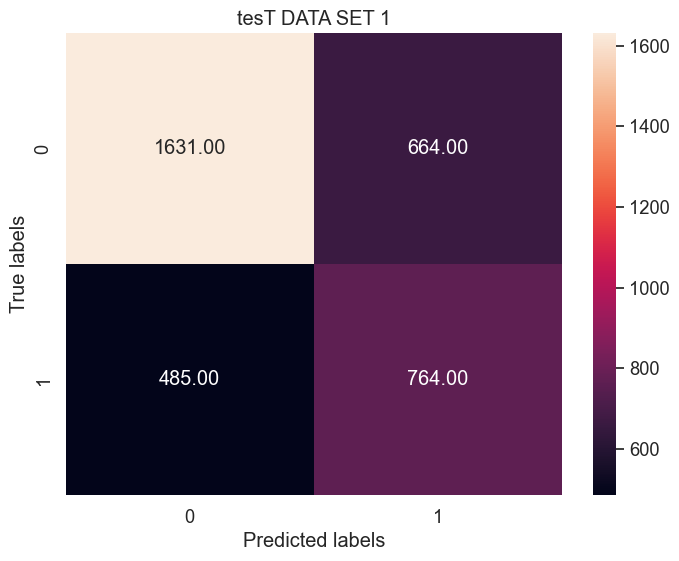

In [39]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(C_1, annot=True,fmt='.2f') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("tesT DATA SET 1")
plt.show()

ROC Curve

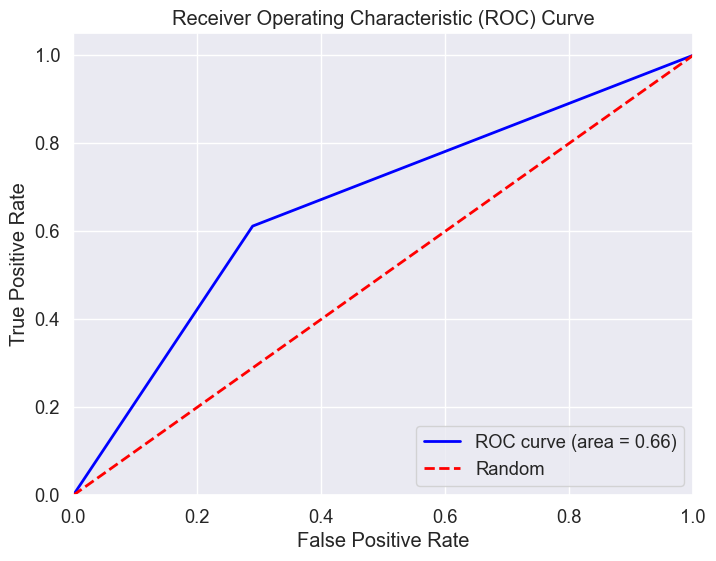

In [40]:
fpr, tpr ,th= roc_curve(L_1,P_1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Results for Data_Set 2

In [48]:
A_2,p_2,R_2,F_2,C_2=calculate_evaluation_metrics(L_2,P_2)

In [49]:
print("For politics Memes DATAset")
print("Accuracy is ",A_2*100)
print("Precision is ",p_2*100)
print("Recall is ",R_2*100)
print("F-1 score is ",F_2*100)
print("True positive Rate (TPR) is",tp*100)
print("False positive Rate (FPR) is",fp*100)

For politics Memes DATAset
Accuracy is  72.80405405405406
Precision is  73.11572700296736
Recall is  70.60171919770774
F-1 score is  71.83673469387755
True positive Rate (TPR) is 61.1689351481185
False positive Rate (FPR) is 28.932461873638342


Confusion Matrix

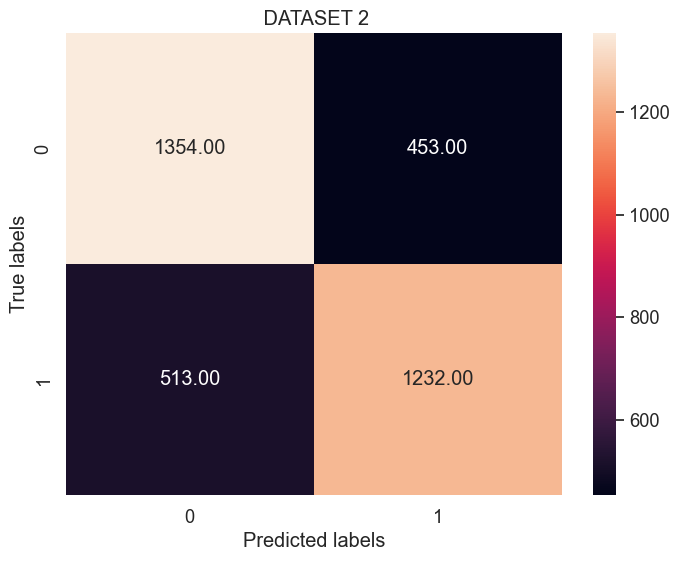

In [50]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(C_2, annot=True,fmt='.2f') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(" DATASET 2")
plt.show()

Roc PLot

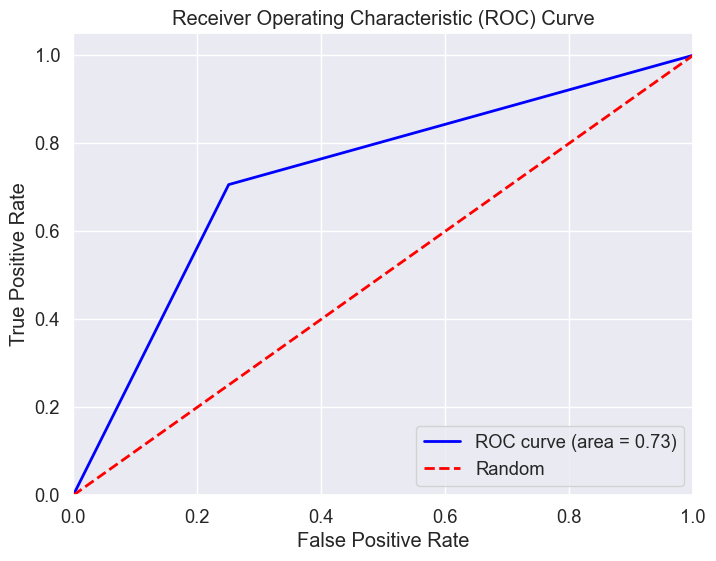

In [51]:
fpr, tpr ,th= roc_curve(L_2,P_2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()